# Практическое занятие №2 - локализация объектов на изображениях

1. Разметка данных с помощью виджета QSL для Jupyter (https://github.com/faustomorales/qsl)
2. Расширение выборки за счет модификации размеченных данных (процедура аугоментация).
3. Знакомство с архитектурой нейронных сетей для локализации объектов на изображении.
4. Обучение нейронных сетей для детекции объектов.
5. Проверка обученной модели для обработки видео потока.
6. Трекинг объектов.
7. Распознавание сцен с помощью простого классификатора.
9. Разработка простой системы управления по данным с видео-камеры.

schema1.svg

In [1]:
#@title
%%html
<video controls width="250">
    <source src="https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_1/video_1.mp4" type="video/mp4"/>
</video>
<video controls width="250">
    <source src="https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/video_3.mp4" type="video/mp4"/>
</video>
<video controls width="250">
    <source src="https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_3/video_4.mp4" type="video/mp4"/>
</video>
<video controls width="250">
    <source src="https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_4/video_4.mp4" type="video/mp4"/>
</video>

# Разметка кадров для обучающей выборки

In [2]:
!pip install -U -q qsl

In [3]:
# Активация расширенных виджетов в Colab (можно закомментировать при запуске в Jupyter)
import google.colab
google.colab.output.enable_custom_widget_manager()

In [4]:
import qsl

In [5]:
%%writefile images.csv
target
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_1/image_001.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_1/image_002.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_1/image_003.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_005.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_006.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_007.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_008.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_009.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_010.jpg
https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_3/image_011.jpg

Overwriting images.csv


In [6]:
import pandas

image_file = pandas.read_csv('images.csv')

In [7]:
labeler = qsl.MediaLabeler(
    items=image_file.to_dict(orient='records'),
    config={
        "regions": [
            {"name": "Object", "multiple": True, "options": [{"name": "bottle"}, {"name": "bug"}]}
        ]
    })
labeler.mode = "dark"
labeler

MediaLabeler(buttons={'prev': False, 'next': True, 'save': True, 'config': True, 'delete': False, 'ignore': Tr…

In [8]:
import json

with open('result.json', 'w') as file:
    file.write(json.dumps(labeler.items, sort_keys=True, indent=4))

In [9]:
labels = None
with open('result.json', 'r') as file:
    labels = file.read()
    print(labels)

[
    {
        "target": "https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_1/image_001.jpg"
    },
    {
        "target": "https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_1/image_002.jpg"
    },
    {
        "target": "https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_1/image_003.jpg"
    },
    {
        "target": "https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_005.jpg"
    },
    {
        "target": "https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_006.jpg"
    },
    {
        "target": "https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_007.jpg"
    },
    {
        "target": "https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/video_2/image_008.jpg"
    },
    {
        "target": "https://github.com/ant-nik/neural_network_course/raw/main/practice_2_d

In [10]:
!wget -O object_masks.json 'https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/object_masks.json'

--2023-02-26 18:42:48--  https://github.com/ant-nik/neural_network_course/raw/main/practice_2_data/object_masks.json
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ant-nik/neural_network_course/main/practice_2_data/object_masks.json [following]
--2023-02-26 18:42:48--  https://raw.githubusercontent.com/ant-nik/neural_network_course/main/practice_2_data/object_masks.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119077 (116K) [text/plain]
Saving to: ‘object_masks.json’

object_masks.json   100%[===================>] 116.29K  --.-KB/s    in 0.01s   

2023-02-26 18:42:48 (7.81 MB/s) - ‘objec

In [11]:
labels = None
with open('object_masks.json', 'r') as file:
    labels = file.read()
label_data = json.loads(labels)

In [12]:
labeler = qsl.MediaLabeler(
    items=label_data,
    
    #image_file.to_dict(orient='records'),
    config={
        "regions": [
            {"name": "Type", "multiple": True, "options": [{"name": "bottle"}, {"name": "bag"}]}
        ]
    })
labeler.labels
labeler.mode = "dark"
labeler

MediaLabeler(buttons={'prev': False, 'next': True, 'save': True, 'config': True, 'delete': True, 'ignore': Fal…

# Нарезка изображений по объектам

In [13]:
class Struct(object):

    def __init__(self, data):
        for name, value in data.items():
            setattr(self, name, self._wrap(value))

    def _wrap(self, value):
        if isinstance(value, (tuple, list, set, frozenset)): 
            return type(value)([self._wrap(v) for v in value])
        else:
            return Struct(value) if isinstance(value, dict) else value

    def __str__(self):
        result = '{'
        first = True
        for field in self.__dict__.keys():
            if not first:
                result += ', '
            else:
                first = False
            result += f'{field}: {str(self.__dict__[field])}'
        return result + '}'

    def __repr__(self):
        return str(self)

In [14]:
labels = [Struct(label) for label in label_data]

In [15]:
from pandas.core.arrays import boolean
from dataclasses import dataclass
import requests
import numpy
import cv2
from collections import namedtuple
import typing


RawObject = namedtuple('RawObject', ['image_url', 'mask_polygon', 'label'])
Point = namedtuple('Point', ['x', 'y'])


@dataclass
class Box:
    cx: float
    cy: float
    w: float
    h: float

    def __add__(self, p: Point):
        return Box(cx=self.cx + p.x, cy=self.cy + p.y, w=self.w, h=self.h)

    @property
    def x1(self):
        return self.cx - self.w/2

    @property
    def x2(self):
        return self.cx + self.w/2

    @property
    def y1(self):
        return self.cy - self.h/2

    @property
    def y2(self):
        return self.cy + self.h/2


def make_default_background(shape):
    back = numpy.random.normal(loc=128, scale=100, size=shape).astype(numpy.uint8)
    back = butterworth(back, 0.04, False, 4, channel_axis=-1)
    return back


class MaskedObjectImage:

    def __init__(self, image, mask, label):
        self.orig_image = image
        self.mask = mask
        self.label = label
        self.__masked = None

    @property
    def masked(self):
        background = make_default_background(self.orig_image.shape)
        masked = self.orig_image.copy()
        index = self.mask == 0
        masked[index] = background[index]
        return masked

    @property
    def image(self):
        return self.orig_image

    def place(self, background: numpy.ndarray,
              pos: typing.Tuple = (0, 0), copy: boolean = True):
        result = None
        if copy:
            result = background.copy()
        else:
            result = background

        if pos[0] > background.shape[1] or pos[1] > background.shape[0]:
            raise Exception(
                'Invalid position={} for background.shape={} (out of range)'
                .format(pos, background.shape))

        index = self.mask == 0
        start_x = pos[0]
        start_y = pos[1]
        result_end_x = None
        result_end_y = None
        image_end_x = None
        image_end_y = None

        if start_x + self.mask.shape[1] <= result.shape[1]:
            result_end_x = start_x + self.mask.shape[1]
            image_end_x = self.mask.shape[1]
        else:
            result_end_x = result.shape[1]
            image_end_x = result.shape[1] - start_x

        if start_y + self.mask.shape[0] <= result.shape[0]:
            result_end_y = start_y + self.mask.shape[0]
            image_end_y = self.mask.shape[0]
        else:
            result_end_y = result.shape[0]
            image_end_y = result.shape[0] - start_y

        copy = result[start_y:result_end_y, start_x:result_end_x, :].copy()
        index = self.mask > 0
        index = index[:image_end_y, :image_end_x]
        copy[index] = self.orig_image[:image_end_y, :image_end_x, :][index]
        result[start_y:result_end_y, start_x:result_end_x, :] = copy

        return result

    @property
    def box(self):
        index = numpy.where(
            self.mask > 0
        )
        min_x = numpy.min(index[1])
        max_x = numpy.max(index[1])
        min_y = numpy.min(index[0])
        max_y = numpy.max(index[0])
        w = max_x - min_x
        h = max_y - min_y
        cx = min_x + w/2
        cy = min_y + h/2

        return Box(
            cx=cx,
            cy=cy,
            w=w,
            h=h)


class MaskedObjectsDataset:

    def __init__(self, metadata: typing.List[Struct]):
        self.metadata = metadata
        self.objects_meta = [
            RawObject(image_url=image.target,
                      label=obj.labels.Type[0],
                      mask_polygon=pandas.DataFrame.from_records(
                          [vars(point) for point in obj.points]))
            for image in self.metadata
            for obj in image.labels.polygons
            ]
        self.basic_images = {}
        self.objects = {}

    def __len__(self) -> int:
        return len(self.objects_meta)

    def __getitem__(self, value) -> MaskedObjectImage:
        if not isinstance(value, slice):
            value = slice(value, value + 1)

        start = value.start
        if start is None:
            start = 0
        stop = value.stop
        if stop is None:
            stop = len(self)
        step = value.step
        if step is None:
            step = 1

        result = []
        for i in range(start, stop, step):
            result.append(self.__get_single_item(i))

        if len(result) == 1:
            result = result[0]

        return result
        
    def __get_single_item(self, i):
        if i not in self.objects:
            self.__create_object(i)

        return self.objects[i]

    def __create_object(self, i):
        object_meta = self.objects_meta[i]
        image = None
        if not object_meta.image_url in self.basic_images:
            responce = requests.get(object_meta.image_url)
            if not responce.status_code == 200:
                raise Exception("Error, cant get image {}: {}".format(
                    object_meta.image_url, responce.status_code))
            raw_bytes = numpy.frombuffer(responce.content, dtype=numpy.uint8)
            self.basic_images[object_meta.image_url] = cv2.cvtColor(
                cv2.imdecode(raw_bytes, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

        basic_image = self.basic_images[object_meta.image_url]
        min_x = int(object_meta.mask_polygon['x'].min()*basic_image.shape[1])
        min_y = int(object_meta.mask_polygon['y'].min()*basic_image.shape[0])
        max_x = int(object_meta.mask_polygon['x'].max()*basic_image.shape[1])
        max_y = int(object_meta.mask_polygon['y'].max()*basic_image.shape[0])
        image = basic_image[min_y:max_y, min_x:max_x, :]
        mask = numpy.zeros(image.shape, dtype=numpy.uint8)
        object_meta.mask_polygon['nx'] = (
            object_meta.mask_polygon['x']*basic_image.shape[1]).map(int) - min_x
        object_meta.mask_polygon['ny'] = (
            object_meta.mask_polygon['y']*basic_image.shape[0]).map(int) - min_y
        cv2.fillPoly(mask, numpy.expand_dims(
            object_meta.mask_polygon[['nx', 'ny']].to_numpy(), axis=0),
            (255, 255, 255))
        self.objects[i] = MaskedObjectImage(
            image=image,
            mask=mask,
            label=object_meta.label)


In [16]:
dataset = MaskedObjectsDataset(metadata=labels)

In [17]:
!pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import plotly.express as plte
import plotly
import plotly.graph_objects as go
from skimage.filters import butterworth

def plot_masked_objects(images):
    if isinstance(images, MaskedObjectImage):
        images = [images]
    for img in images:
        fig = plotly.subplots.make_subplots(
            horizontal_spacing=0.0, vertical_spacing=0.0,
            rows=1, cols=3, shared_yaxes=True, shared_xaxes=True)
        fig.add_trace(go.Image(z=img.orig_image), row=1, col=1)
        fig.add_trace(go.Image(z=img.mask), row=1, col=2)
        fig.add_trace(go.Image(z=img.masked), row=1, col=3)
        fig.show()

In [19]:
plot_masked_objects(dataset[14])

# Расширение обучающей выборки 

На практике не всегда удается собрать достаточно размеченного материала для качественного обучения нейронной сети. Кроме того, использование большого массива изображений без должного анализа состава приводит к разбалансировке процесса обучения. Например, в общем потоке изображений какие-либо классы объектов могут быть представлены незначительным числом примеров и по этой причине их распознавание во время обучения будет иметь малую значимость на фоне остальных классов. В этой связи все современные модели при обучении предполагают в определенной степени крапотливое конструирование синтетического набора данных на основе исходных изображений. Подробный обзор стратегий расширения выборки за счет изменения исходных изображений представлен в статье "A Comprehensive Survey of Image Augmentation Techniques for Deep Learning" (https://arxiv.org/abs/2205.01491).

Далее будем использовать следующий способ расширения выборки изображений.
1. Извлечение изображений интересующих нас объектов из исходных данных.
2. Создание набора фоновых изображений для размещения объектов.
3. Определение набора трасформаций изображений объектов и фона, включая масштабирование, отражения, повороты, обрезку, изменение цвета/насыщенности, наложение шума.
4. Размещение объектов на фоне в случайных местах.

В настоящее время нет необходимости реализовывать с нуля все шаги синтеза изображений, т.к. существуюет большой набор готовых решений. Наиболее популярными решениями служат следующие пакеты Python.

1. https://pytorch.org/vision/stable/transforms.html
2. https://www.tensorflow.org/tutorials/images/data_augmentation?hl=en
3. https://augmentor.readthedocs.io/en/master/
4. https://github.com/albumentations-team/albumentations

Важным вопросом при расширении выборки является выбор параметров. Он может быть выполнен как эмпирически, так и путем оптимизации. В последнем случае используют либо целевую модель, либо её малый эквивалент с целью вариации параметров и оценки качества обучения. Логичным итогом такого рода работы становятся так называемые "системы автоаугоментации", в которые встраивается универсальная внутренняя модель и алгоритм оптимизации для подбора параметров трансформаций. Они могут использоваться для расширения новых наборов данных без дополнительных усилий со стороны разработчика (но ценой значительного расхода вычислений, т.к. необходимо многократно проводить процесс обучения моделей). Более подробно об основной идее такого автоматического подхода можно почитать в статье сотрудников компании Google (https://arxiv.org/abs/1805.09501), а также изучить похожую реализацию в пакете deepaugment - https://github.com/barisozmen/deepaugment (к сожалению, пакет больше не поддерживается, последнее обновление исходного кода было в 2019 году).
Далее будем использовать более простой "эмпирический способ".



In [20]:
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import albumentations as aug

transform = aug.Compose([
    aug.CropAndPad(percent=(0.2, 0.2), keep_size=False,
                   pad_mode=cv2.BORDER_CONSTANT),
    aug.LongestMaxSize(max_size=300),
    aug.Rotate(p=0.9, border_mode=cv2.BORDER_CONSTANT,
               value=(0, 0, 0), mask_value=(0, 0, 0)),
    # aug.RandomCrop(width=50, height=50, p=0.25),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomScale(scale_limit=0.5, always_apply=True),
    aug.MotionBlur(),
    aug.RGBShift(always_apply=True,
                 r_shift_limit=20, g_shift_limit=20, b_shift_limit=20),
    aug.HueSaturationValue(always_apply=True, p=1.0),
    aug.RandomBrightnessContrast(p=0.2),
    aug.GaussNoise(always_apply=True)
])

In [22]:
import random

def sample_image(
    images: typing.List[MaskedObjectImage],
    transf: aug.Compose) -> MaskedObjectImage:
    choice = int(random.random()*len(images))
    sample = transf(image=images[choice].image, mask=images[choice].mask)
    return MaskedObjectImage(image=sample['image'],
                             mask=sample['mask'],
                             label=images[choice].label)

In [23]:
num_of_samples = 1
plot_masked_objects([
    sample_image(images=[dataset[1:2]], transf=transform)
    for i in range(0, num_of_samples)])


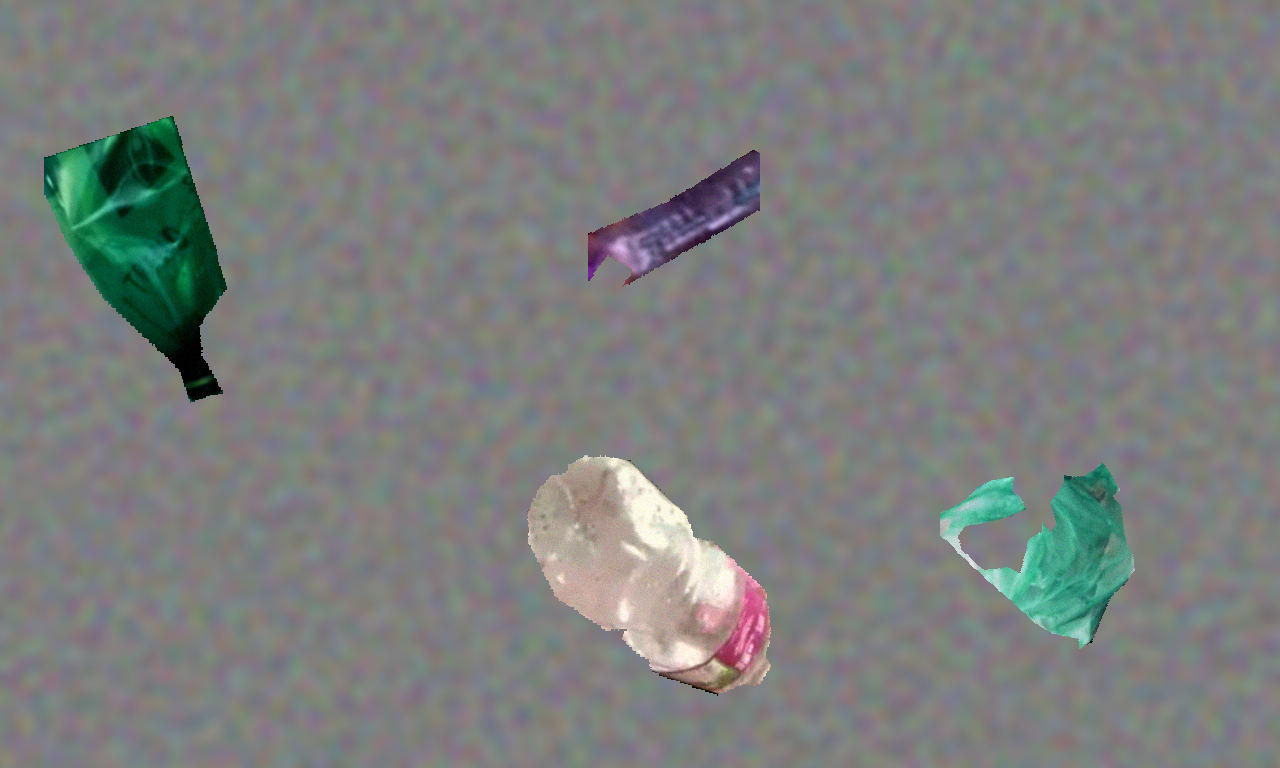

In [29]:
from skimage.filters import butterworth

def generate_objects_image(
    objects: MaskedObjectsDataset,
    size: typing.Tuple[int, int, int],
    N: int
    ) -> typing.Tuple[numpy.ndarray, typing.List[Box]]:

    result = butterworth(make_default_background(size), 0.1, False, 4,
                        channel_axis=-1)
    boxes = []
    for i in range(0, N):
        image = sample_image(images=dataset, transf=transform)
        pos = Point(
            x=int(random.random()*(result.shape[1] - image.mask.shape[1])),
            y=int(random.random()*(result.shape[0] - image.mask.shape[0])))
        result = image.place(
            background=result,
            pos=pos
        )
        boxes.append(image.box + pos)
                
    return result, boxes

image, boxes = generate_objects_image(
    objects=dataset,
    size=(768, 1280, 3),
    N=4
)
f = plte.imshow(image)
for b in boxes:
    f.add_trace(go.Scatter(
        x=[b.x1, b.x1, b.x2, b.x2, b.x1],
        y=[b.y1, b.y2, b.y2, b.y1, b.y1]))
f.show()